In [17]:
import sys
sys.path.append('src')

from unet_preprocessing import DataProcessor
#from unet_prediction import ImagePadding
from model import unet, unet_inference, unet_reduced, unet_reduced_inference

import numpy as np
import matplotlib.pyplot as plt
from skimage import io

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping

In [228]:
def scale_pixel_vals(img):
    img = np.array(img)
    return ((img - img.min())/(img.max() - img.min()))

def generate_patches(img, mask, weight_map = None, mask_splitting_event=None):
    # generate x-, y-coordinates of patches
    div = 8 #divisor of patch size
    num_patches = 4
    shift_r = int(img.shape[0]/(num_patches*2))
    shift_c = int(img.shape[1]/(num_patches*2))
    #shift_r = int(img.shape[0]/9)
    #shift_c = int(img.shape[1]/9)
    #rows = np.linspace(shift_r,img.shape[0]-shift_r,int(img.shape[0]/shift_r)).astype(int)[:-1]
    rows = np.arange(shift_r,img.shape[0],shift_r*2).astype(int)
    #cols = np.linspace(shift_c,img.shape[1]-shift_c,int(img.shape[1]/shift_c)).astype(int)[:-1]
    cols = np.arange(shift_c,img.shape[1],shift_c*2).astype(int)
    rows, cols = np.meshgrid(rows, cols)
    rows = rows.flatten()
    cols = cols.flatten()

    imgs = []
    masks = []
    #weight_maps = []
    if mask_splitting_event is not None:
        masks_splitting_events = []
    #s = shift
    for r, c in zip(rows, cols):
        imgs.append(img[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))
        mask_patch = mask[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1))
        masks.append(mask_patch)
        #weight_maps.append(weight_map[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))
        if mask_splitting_event is not None:
            masks_splitting_events.append(mask_splitting_event[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))
    imgs = np.array(imgs)
    masks = np.array(masks)
    #weight_maps = np.array(weight_maps)
    if mask_splitting_event is not None:
        masks_splitting_events = np.array(masks_splitting_events)

    if mask_splitting_event is not None:
        return imgs, masks, weight_maps, masks_splitting_events
    else:
        return imgs, masks

def generate_random_patches(img, mask, img_shape, weight_map = None, mask_splitting_event=None):
    # generate x-, y-coordinates of patches
    div = 8 #divisor of patch size
    num_patches = 10
    
    # set size of shift and patch
    shift_r = 64 
    shift_c = 64
    rows = np.linspace(shift_r, img.shape[0] - shift_r, 10).astype(int)
    cols = np.linspace(shift_c, img.shape[1] - shift_c, 10).astype(int)

    rows, cols = np.meshgrid(rows, cols)
    rows = rows.flatten()
    cols = cols.flatten()

    imgs = []
    masks = []
    #weight_maps = []
    if mask_splitting_event is not None:
        masks_splitting_events = []
    #s = shift
    shifts_r = []
    shifts_c = []
    for r, c in zip(rows, cols):
        shifts_r.append(r+shift_r)
        shifts_c.append(c+shift_c)
        imgs.append(img[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))
        mask_patch = mask[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1))
        masks.append(mask_patch)
        #weight_maps.append(weight_map[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))
        if mask_splitting_event is not None:
            masks_splitting_events.append(mask_splitting_event[r-shift_r:r+shift_r, c-shift_c:c+shift_c].reshape((shift_r*2, shift_c*2, 1)))

    imgs = np.array(imgs)
    masks = np.array(masks)
    print(np.max(shifts_r))
    print(np.max(shifts_c))
    #weight_maps = np.array(weight_maps)
    if mask_splitting_event is not None:
        masks_splitting_events = np.array(masks_splitting_events)

    if mask_splitting_event is not None:
        return imgs, masks, weight_maps, masks_splitting_events
    else:
        return imgs, masks

In [229]:
path = 'data/data_Glen/unet/mCherry/'
proc = DataProcessor(path)

path_base = 'data/data_Glen/unet/mCherry/'
path_img = [path_base + 'pos33-mCherry_dual-A10200_cut.png', path_base + 'GD_04092019AlgCo_Cas_Pos57_TXRED_Exp001_frame100_cut.png']
path_mask = [path_base + 'pos33-mCherry_dual-A10200_seg_2_new.png', path_base + 'GD_04092019AlgCo_Cas_Pos57_TXRED_Exp001_frame100_seg3_bin.png']
#path_img_test = path_base + 'pos33-mCherry_dual-A10100_cut.png'

In [230]:
img = scale_pixel_vals(io.imread(path_img[0]))
img_shape = img.shape
mask = scale_pixel_vals(io.imread(path_mask[0])).astype(int)

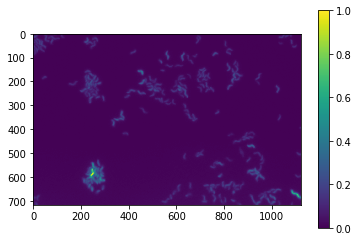

In [231]:
plt.imshow(img)
plt.colorbar()

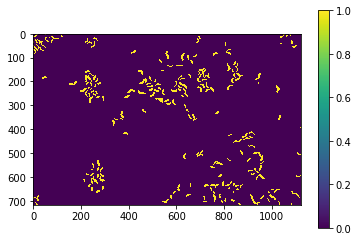

In [232]:
plt.imshow(mask)
plt.colorbar()

In [233]:
imgs, masks = generate_patches(img, mask)

In [234]:
imgs.shape

(16, 178, 280, 1)

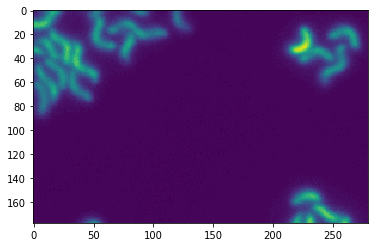

In [235]:
plt.imshow(imgs[0,:,:,0])

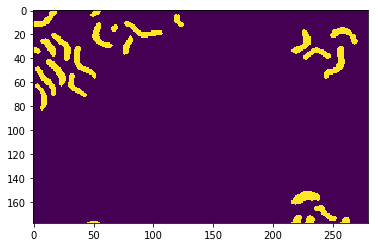

In [236]:
plt.imshow(masks[0,:,:,0])

In [237]:
X_train_rand, y_train_rand = \
generate_random_patches(imgs[1], masks[1], img_shape)

64 114
64 216
178
280


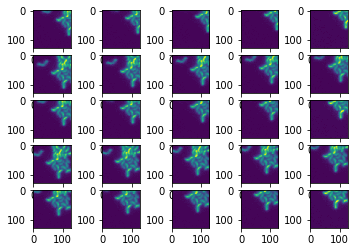

In [238]:
ix = 0
for i in range(75,100):
    plt.subplot(5,5,ix+1)
    plt.imshow(X_train_rand[i,:,:,0])
    ix+=1

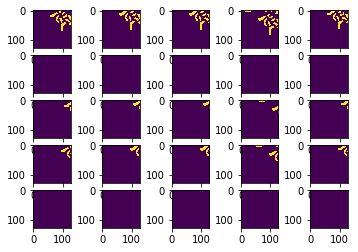

In [143]:
for i, x in enumerate(y_train_rand):
    plt.subplot(5,5,i+1)
    plt.imshow(y_train_rand[i,:,:,0])

In [208]:
X_train_rand.shape

(100, 128, 128, 1)